In [1]:
import numpy as np
from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
from sklearn import datasets, model_selection as ms
from sklearn.linear_model import LogisticRegression
from skimage.transform import rotate
%matplotlib inline

Write code to augment black-and-white image data.  It should

1. Accept a numpy array X of images (so X[i] is a 2-dimensional array of pixel values corresponding to the ith image), a maximum rotation d (say in degrees), a shift factor s (measured in pixels), a zoom factor z (ranging say from 1 to 2)
2. For each image randomly rotate the image by some amount in (-d, d)
3. For each image, randomly shift up by some number of pixels in (-s,s) and also randomly shift right by some other number of pixels in (-s,s).
4. Randomly zoom in on the center of the image by a factor that is no less than 1/z and no more than z.
5. Return a new array of rotated, shifted, zoomed and padded images.
6. EXTRA CREDIT: fix things so that pixels on the edge that might otherwise default to black (because they are not in the rotated or shifted or zoomed image) are given some appropriate value so that sharp new edges are not introduced by the transformations (that is, if you pad with black, you may well be causing new artifacts that your learner might be confused by, so you want to pad the edge with something less severe--maybe use some sort of smoothing function or use the average of nearby pixels.)

In [2]:
def augment(X, d, s, z):
    '''
    Augments a sets of images (X) by randomly rotating, shifting, and zooming
    according to parameters d, s, and z.
    
    Arguments:
    X (ndarray) - 3 dimensional array of grayscale pictures
    d (int) - maximal degree to rotate in either direction
    s (int) - maximal # of pixels to shift in any direction
    z (float) - will zoom by some random number between [1/z, z]
    
    Returns:
    Xnew (ndarray) - 3 dimension array of the augmented grayscale pictures
    '''
    Xnew = np.zeros_like(X)
    
    # randomly rotate the image
    angle = np.random.random(len(X))*2*d - d
    for i in range(len(X)):
        Xnew[i] = rotate(X[i], angle[i])
    
    # randomly shift up
    vertical = np.random.randint(-s, s+1, len(X))
    for i in range(len(X)):
        if vertical[i] < 0:
            temp = Xnew[i][-1,:]   # Save edge and replicate it so there isn't a harsh color change
            Xnew[i] = np.roll(Xnew[i], vertical[i], axis=0)
            Xnew[i][vertical[i]:,:] = temp
        elif vertical[i] > 0:
            temp = Xnew[i][0,:]
            Xnew[i] = np.roll(Xnew[i], vertical[i], axis=0)
            Xnew[i][:vertical[i],:] = temp
    
    # randomly shift right
    horizontal = np.random.randint(-s, s+1, len(X))
    for i in range(len(X)):
        if horizontal[i] < 0:
            temp = Xnew[i][:,-1]   # Save edge and replicate it so there isn't a harsh color change
            Xnew[i] = np.roll(Xnew[i], horizontal[i], axis=1)
            Xnew[i][horizontal[i]:,:] = temp
        elif horizontal[i] > 0:
            temp = Xnew[i][:,0]
            Xnew[i] = np.roll(Xnew[i], horizontal[i], axis=1)
            Xnew[i][:horizontal[i],:] = temp
    
    # randomly zoom
    scale = np.random.random(len(X))*(z - 1./z) + 1./z
    for i in range(len(X)):
        Xnew[i] = rotate(Xnew[i], scale[i])
    
    #return new array of images
    return Xnew

Show the results of your augmentation code applied to the first 10 images in the scikit-learn digits dataset (that is, plot the images before and after your code is applied.)

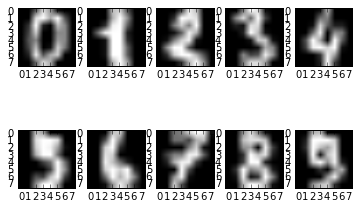

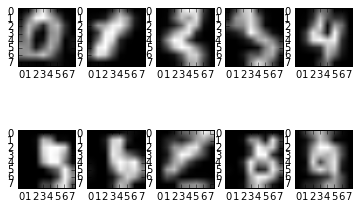

In [3]:
# plot original images
digits = datasets.load_digits()
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(digits.images[i], cmap='gray')
plt.show()

# plot augmented images
shifted = augment(digits.images[:10],30,1,1.3)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(shifted[i], cmap='gray')
plt.show()

Split the scikit-learn digits dataset into an 60-40 train-test split and apply your data augmentation code to the training set to make a new training data set that is the original training set AND the augmented data.   Compare (on they test set) the accuracy of a softmax classifier trained on the big data set  versus one trained on the original training set.

In [4]:
# split dataset 60/40
X,y = digits.images, digits.target
xtrain, xtest, ytrain, ytest = ms.train_test_split(X,y,test_size = .4)

# create augmented data
augmented_train = augment(xtrain, 30, 1, 1.3).reshape((xtrain.shape[0], 64))
xtrain = xtrain.reshape((xtrain.shape[0], 64))
augmented_train = np.concatenate((xtrain, augmented_train))
xtest = xtest.reshape((xtest.shape[0], 64))

# apply code to training sets
model = LogisticRegression(multi_class = 'multinomial', solver='newton-cg')
model.fit(xtrain, ytrain)
original_acc = (model.predict(xtest) == ytest).mean()
model.fit(augmented_train, np.concatenate((ytrain,ytrain)))
augmented_acc = (model.predict(xtest) == ytest).mean()

# compare accuracy
print("Original Training Set:\t{}\nAugmented Training Set:\t{}".format(original_acc, augmented_acc))

Original Training Set:	0.956884561892
Augmented Training Set:	0.922114047288
